
### 01 - Data Exploration
![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import load_model # type: ignore
from tensorflow.keras.preprocessing import image  # type: ignore
from sklearn.model_selection import train_test_split
from PIL import Image
import glob

In [ ]:
# Load data and Explore Classes
# ===================================================================

ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

# Visualize Data
# ===================================================================

# vis = tfds.visualization.show_examples(ds, info)


### 02 - Data Preparation
![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


In [ ]:
# Load data
# Then Divide the data into 70:15:15 ratio
# ===================================================================

BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

train_ds, val_ds, test_ds = tfds.load('malaria',split = ['train[:70%]',
                                                         'train[70%:85%]',
                                                         'train[85%:]'],
                                      shuffle_files = True,
                                      as_supervised = True)


In [ ]:
# Not all images are of size (200, 200)
# Crop bigger images as well as pad smaller ones to attain (200, 200)
# ===================================================================

def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label


# Apply the functions to train and val images
# ===================================================================

padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 


### 03 - Model Buidling
![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


In [ ]:
# Build the CNN layers
# We define our convolution layers as well as our dense block
# ===================================================================

def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

In [ ]:
# We then define our model
# ===================================================================

def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model



# Compile the model
# ===================================================================

model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[tf.keras.metrics.AUC(name='auc')]
)

In [ ]:
# Adjust Hyperparameters
# Set the model Learning Rate
# Save only the best calculated weights from the model
# ===================================================================

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model_2.keras",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)


### 04 - Train and Evaluate Model
![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


In [ ]:
# Train Model
# ===================================================================

history = model.fit(
    padded_train_ds, epochs=20,
    validation_data=padded_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

In [ ]:
# Evaluate Model
# ===================================================================

padded_test_ds = (
     test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

model.evaluate(padded_test_ds)
# model.summary()


### 05 - Test Predictions
![purple-divider](https://user-images.githubusercontent.com/7065401/52071927-c1cd7100-2562-11e9-908a-dde91ba14e59.png)


In [ ]:
# Define a function to save the images
def save_images(dataset, folder_path, limit):
    for i, example in enumerate(dataset):
        # Stop saving images after reaching the limit
        if i >= limit:
            break

        # Get the image from the example
        image = example["image"].numpy()
        
        # Convert the image array to an Image object
        image = Image.fromarray(image)
        
        # Save the image
        image.save(os.path.join(folder_path, f'image_{i}.png'))

# Create a directory if it doesn't exist
if not os.path.exists('Images'):
    os.makedirs('Images')

# Call the function to save the images
save_images(ds, 'Images', 50)

In [223]:
# Specify the path to your saved model
model_path = 'malaria_model_2.keras'

# Load the model
model2 = tf.keras.models.load_model(model_path)

ValueError: Attempt to convert a value (<module 'tensorflow.keras.preprocessing.image' from '/home/allan/.virtualenvs/DSC/lib/python3.10/site-packages/keras/_tf_keras/keras/preprocessing/image/__init__.py'>) with an unsupported type (<class 'module'>) to a Tensor.

In [231]:
folder_path = 'Images'

# load all images into a list
images = []
image_list = []
for img in os.listdir(folder_path):
    img_path = os.path.join(folder_path, img)
    img = image.load_img(img_path, target_size=(200, 200))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    images.append(img_array)
    image_list.append(img)

# stack up images list to pass for prediction
images = np.vstack(images)
classes = model2.predict(images, batch_size=10)

# Convert predictions to class names based on the threshold
class_names_predicted = ['Parasitized' if classes < 0.5
                         else 'Uninfected' for classes in classes]

5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step


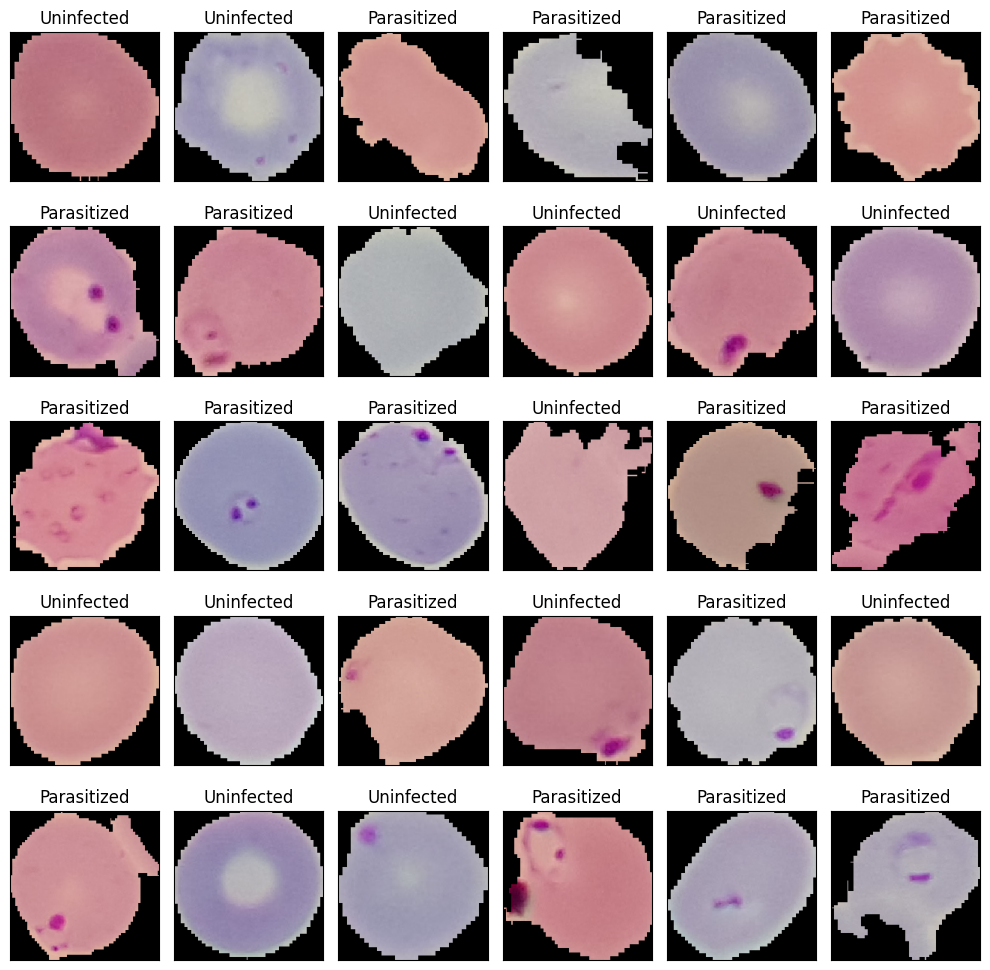

In [225]:
# Plot the images along with their predicted classes
fig = plt.figure(figsize=(10, 10))
for i in range(min(30, len(image_list))):  # Limit the number of images to 10
    ax = fig.add_subplot(5, 6, i+1)
    ax.imshow(image_list[i])
    ax.set_title(class_names_predicted[i])
    ax.yaxis.set_visible(False)
    ax.xaxis.set_ticks([])
plt.tight_layout()
plt.show()